In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("./"))
import librosa
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.stats import skew
import time
SAMPLE_RATE = 44100

from tqdm import tqdm
import scipy
data_path = './'
# ss = pd.read_csv(os.path.join(data_path, 'sample_submission.csv'))

['CNN No-Hierarchy_torch-Copy1.ipynb', 'CNN Multi-layer.ipynb', 'mixd_mult.py', 'Feature Reduction Tests.ipynb', 'CNN', 'dnnmult.py', 'Hybrid Multi-layer D+B.ipynb', 'AUC-ROC Curve.ipynb', 'load_blockwise.py', 'CNN No-Hierarchy_1.ipynb', 'DNN_baseline.ipynb', 'Hybrid Multi-layer D+B No Prob.ipynb', 'ablation_analysis.ipynb', '__pycache__', 'Hybrid Multi-layer Derived.ipynb', 'data1', 'KNN', '.ipynb_checkpoints', 'SVM No-Hierarchy.ipynb', 'DNN', 'data2', 'RNN', 'SVM.ipynb', 'myImage.png', 'DNN Multi-layer.ipynb', 'output1.png', 'CNN Hierarchical reproduce_new.ipynb', 'data3', 'model_40.pt', 'CNN Hierarchical reproduce.ipynb', 'RFC', 'SVM', 'hierarchical_cnn.pt', 'DNN No-Hierarchy.ipynb', 'toy_model.pt', 'CNN No-Hierarchy_reproduce.ipynb', 'model_60.pt', 'cnnmult.py', 'data', 'hybmulder.py', 'output3.png', 'toy_model_20.pt', 'CNN No-Hierarchy_reproduce_new.ipynb', 'model_v0.pt', 'output2.png']


In [6]:
#loading data
audio_train_files = os.listdir('../../ESC-50/audio/')
# audio_test_files = os.listdir('./audio_test')

train = pd.read_csv('../../ESC-50/meta/esc50.csv')
# submission = pd.read_csv('./sample_submission.csv')

In [5]:
def clean_filename(fname, string):   
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':        
        file_name = string + file_name
    return file_name

#returns mfcc features with mean and standard deviation along time
def get_mfcc(name, path):
    b, _ = librosa.core.load(path + name, sr = SAMPLE_RATE)
    assert _ == SAMPLE_RATE
    try:
        gmm = librosa.feature.mfcc(b, sr = SAMPLE_RATE, n_mfcc=20)
        return pd.Series(np.hstack((np.mean(gmm, axis=1), np.std(gmm, axis=1), skew(gmm, axis = 1), np.median(gmm, axis = 1))))
    except:
        print('bad file')
        return pd.Series([0]*80)

In [8]:
#preparing data
train_data = pd.DataFrame()
train_data['fname'] = train['filename']

s_time = time.time()
train_data = train_data['fname'].apply(get_mfcc, path='../../ESC-50/audio/')
print('done loading train mfcc')
e_time = time.time()
print(e_time - s_time)

train_data['fname'] = train['filename']
train_data['label'] = train['target']

done loading train mfcc
88.84048366546631


In [9]:
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,72,73,74,75,76,77,78,79,fname,label
0,-581.741028,8.207122,-6.658803,-4.290907,-3.034478,0.259279,-1.963946,-0.271577,0.518284,0.341884,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1-100032-A-0.wav,0
1,-254.768875,85.773117,-107.046455,30.983374,-39.900375,-17.297678,-37.187698,-18.157551,-11.678356,-17.608614,...,-9.540938,-21.301386,-10.129757,-15.261668,-11.477957,-7.971982,-10.199671,-8.668966,1-100038-A-14.wav,14
2,-30.370251,102.513847,-40.429382,39.036438,-22.459366,12.783750,-8.461548,20.706306,-11.602804,18.954430,...,-11.740995,24.106976,-9.308275,21.862791,7.255868,-3.559335,-0.471733,8.571336,1-100210-A-36.wav,36
3,-31.078880,104.311043,-43.096546,42.293327,-26.298584,18.351303,-10.633704,22.366919,-12.204813,16.524916,...,-7.795380,22.887140,-7.850013,20.951759,7.656289,-3.100060,0.558044,6.651339,1-100210-B-36.wav,36
4,-466.546082,144.254364,22.956766,52.225941,2.967250,11.320632,-2.910913,0.082192,-8.928229,10.030496,...,-11.050064,4.063751,-8.152941,-5.815808,-0.979070,-4.708130,-3.514111,0.301816,1-101296-A-19.wav,19


In [12]:
#Features from LightGBM baseline kernel: https://www.kaggle.com/opanichev/lightgbm-baseline
# MAPk from https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])


def extract_features(files, path):
    features = {}

    cnt = 0
    for f in tqdm(files):
        features[f] = {}

        fs, data = scipy.io.wavfile.read(os.path.join(path, f))

        abs_data = np.abs(data)
        diff_data = np.diff(data)

        def calc_part_features(data, n=2, prefix=''):
            f_i = 1
            for i in range(0, len(data), len(data)//n):
                features[f]['{}mean_{}_{}'.format(prefix, f_i, n)] = np.mean(data[i:i + len(data)//n])
                features[f]['{}std_{}_{}'.format(prefix, f_i, n)] = np.std(data[i:i + len(data)//n])
                features[f]['{}min_{}_{}'.format(prefix, f_i, n)] = np.min(data[i:i + len(data)//n])
                features[f]['{}max_{}_{}'.format(prefix, f_i, n)] = np.max(data[i:i + len(data)//n])

        features[f]['len'] = len(data)
        if features[f]['len'] > 0:
            n = 1
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')

            n = 2
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')

            n = 3
            calc_part_features(data, n=n)
            calc_part_features(abs_data, n=n, prefix='abs_')
            calc_part_features(diff_data, n=n, prefix='diff_')


        cnt += 1

        # if cnt >= 1000:
        #     break

    features = pd.DataFrame(features).T.reset_index()
    features.rename(columns={'index': 'fname'}, inplace=True)
    
    return features

path = "../../ESC-50/audio/"
train_files = train.filename.values
train_features = extract_features(train_files, path)

100%|██████████| 2000/2000 [00:29<00:00, 67.91it/s]


In [13]:
train_data = train_data.merge(train_features, on='fname', how='left')
train_data.to_csv("./train_df.csv")
train_data.head()

,0,1,2,3,4,5,6,7,8,9,...,min_1_3,max_1_3,abs_mean_1_3,abs_std_1_3,abs_min_1_3,abs_max_1_3,diff_mean_1_3,diff_std_1_3,diff_min_1_3,diff_max_1_3
0,-581.741028,8.207122,-6.658803,-4.290907,-3.034478,0.259279,-1.963946,-0.271577,0.518284,0.341884,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,-254.768875,85.773117,-107.046455,30.983374,-39.900375,-17.297678,-37.187698,-18.157551,-11.678356,-17.608614,...,-5336.0,4553.0,783.556857,624.554197,0.0,5336.0,-1099.5,137.5,-1237.0,-962.0
2,-30.370251,102.513847,-40.429382,39.036438,-22.459366,12.783750,-8.461548,20.706306,-11.602804,18.954430,...,-32141.0,32767.0,7447.340422,5258.252535,0.0,32767.0,-8262.5,921.5,-9184.0,-7341.0
3,-31.078880,104.311043,-43.096546,42.293327,-26.298584,18.351303,-10.633704,22.366919,-12.204813,16.524916,...,-32768.0,32767.0,6052.735306,5143.856077,-32768.0,32767.0,-286.0,777.0,-1063.0,491.0
4,-466.546082,144.254364,22.956766,52.225941,2.967250,11.320632,-2.910913,0.082192,-8.928229,10.030496,...,-1142.0,1049.0,158.945646,137.849542,0.0,1142.0,-26.0,5.0,-31.0,-21.0


In [14]:
#Functions from LightGBM baseline: https://www.kaggle.com/opanichev/lightgbm-baseline
# Construct features set
train_data = pd.read_csv("./train_df.csv")
X = train_data.drop(['label', 'fname'], axis=1)
feature_names = list(X.columns)
X = X.values
labels = np.sort(np.unique(train_data.label.values))
num_class = len(labels)
c2i = {}
i2c = {}
for i, c in enumerate(labels):
    c2i[c] = i
    i2c[i] = c
y = np.array([c2i[x] for x in train_data.label.values])

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

rfc = RandomForestClassifier(n_estimators = 150)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, shuffle = True)
rfc.fit(X_train, y_train)
#more functions from LightGBM baseline: https://www.kaggle.com/opanichev/lightgbm-baseline
def proba2labels(preds, i2c, k=3):
    ans = []
    ids = []
    for p in preds:
        idx = np.argsort(p)[::-1]
        ids.append([i for i in idx[:k]])
        ans.append(' '.join([i2c[i] for i in idx[:k]]))

    return ans, ids
#checking the accuracy of the model
print(rfc.score(X_val, y_val))

0.5675


In [14]:
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10, shuffle = True)

(7578, 118)

In [37]:
import torch.nn as nn
import torch.nn.functional as F

# class Net(nn.Module):
#     def __init__(self,):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(118, 64)
#         self.fc2 = nn.Linear(64, 50)
#         self.norm1 = nn.BatchNorm1d(64)
#         self.dropout = nn.Dropout2d(p=0.2)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.norm1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
# #         x = self.dropout(x)
#         x = self.softmax(x)
#         return x

class Net(nn.Module):
    def __init__(self,):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(118, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, 50)
        self.norm1 = nn.BatchNorm1d(128)
        self.norm2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout2d(p=0.2)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.fc1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.norm2(x)
        x = F.relu(x)
#         x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x
    
    
# class Net(nn.Module):
#     def __init__(self,):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(118, 128)
#         self.fc2 = nn.Linear(128, 128)
#         self.fc3 = nn.Linear(128,64)
#         self.fc4 = nn.Linear(64,64)
#         self.fc5 = nn.Linear(64, 41)
#         self.norm1 = nn.BatchNorm1d(128)
#         self.norm2 = nn.BatchNorm1d(64)
#         self.dropout = nn.Dropout2d(p=0.2)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.norm1(x)
#         x = F.relu(x)
#         x = self.fc2(x)
#         x = self.norm1(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = self.norm2(x)
#         x = F.relu(x)
#         x = self.fc4(x)
#         x = self.norm2(x)
#         x = F.relu(x)
# #         x = self.dropout(x)
#         x = self.fc5(x)
#         x = self.softmax(x)
#         return x

# class Net(nn.Module):
#     def __init__(self,):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(118, 128)
#         self.fc2 = nn.Linear(128, 64)
#         self.fc3 = nn.Linear(64,128)
#         self.fc4 = nn.Linear(64,64)
#         self.fc5 = nn.Linear(64, 50)
#         self.norm1 = nn.BatchNorm1d(256)
#         self.norm2 = nn.BatchNorm1d(128)
#         self.norm3 = nn.BatchNorm1d(64)
#         self.dropout = nn.Dropout2d(p=0.2)
#         self.softmax = nn.Softmax()

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.norm1(x)
#         x = F.relu(x)
# #         x = self.dropout(x)
#         x = self.fc2(x)
#         x = self.norm2(x)
#         x = F.relu(x)
#         x = self.fc3(x)
#         x = self.norm3(x)
#         x = F.relu(x)
#         x = self.fc4(x)
#         x = self.norm3(x)
#         x = F.relu(x)
# #         x = self.dropout(x)
#         x = self.fc5(x)
#         x = self.softmax(x)
#         return x    

In [17]:
# load data:
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import Counter

class audiodata(Dataset):
    def __init__(self):
        
        self.data = pd.read_csv("./train_df.csv")
        X = self.data.drop(['label', 'fname'], axis=1)
        feature_names = list(X.columns)
        X = X.values
        labels = np.sort(np.unique(train_data.label.values))
        num_class = len(labels)
        c2i = {}
        i2c = {}
        for i, c in enumerate(labels):
            c2i[c] = i
            i2c[i] = c
        y = np.array([c2i[x] for x in train_data.label.values])
        
            
    
        self.data_list = X
        self.label_list = y
        
#         print(self.data_list)
        print(len(self.data_list), len(self.label_list))
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):
        
        data = self.data_list[index]
        label= self.label_list[index] 
        label = np.asarray(label)
#         print(data.shape,label.shape)
        return data, label

data = audiodata()
# data.__getitem__(1)

2000 2000


In [40]:
#### new spectrogram
import torch.optim as optim
import torch
import time
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler

model = Net()
print(model)
model = model#.cuda()
pp=0
for p in list(model.parameters()):
    nnd=1
    for s in list(p.size()):
        nnd = nnd*s
    pp += nnd
print(pp)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0000)
scheduler = StepLR(optimizer, step_size=50, gamma=0.5)

random_seed= 42
shuffle_dataset = True
dataset_size = 2000
batch_size = 64

validation_split = .2
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
dataset  = audiodata()
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


val_history = []
val_loss_hist = []
train_history = []
train_loss_hist = []

for epoch in range(400):  # loop over the dataset multiple times
    
########## Validation ###########
    
    count = 0
    running_accuracy = 0
    running_loss = 0
    t1 = time.time()
    for i, data in enumerate(testloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs#.cuda()
        labels = labels#.cuda()
        outputs = model(inputs)
        val_loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        acc_val = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_val.item()
        running_loss += val_loss.item()
        
    running_accuracy /= count
    running_loss /= count
    val_history.append(running_accuracy)
    val_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Val============")
    print("Validation Time: {}".format(t2 - t1))
    print("Epoch: {}  val_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  val_accuracy: {}".format(epoch, running_accuracy))
    
######### Training ###########   
    
    running_loss = 0.0
    count = 0
    running_accuracy = 0
    t1 = time.time()
    for i, data in enumerate(trainloader, 0):
        count += 1
        inputs, labels = data
        inputs = inputs.float()
        inputs = inputs#.cuda()
        labels = labels#.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        acc_train = torch.eq(preds, labels).float().mean()
        running_accuracy += acc_train.item()
        
    scheduler.step()
    running_accuracy /= count
    running_loss /= count
    train_history.append(running_accuracy)
    train_loss_hist.append(running_loss)
    t2 = time.time()
    print("===========Phase: Train============") 
    print("Training Time: {}".format(t2 - t1))
    print("Epoch: {}  train_loss: {}".format(epoch, running_loss))
    print("Epoch: {}  train_accuracy: {}".format(epoch, running_accuracy))
    print()
        
print('Finished Training')

Net(
  (fc1): Linear(in_features=118, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=50, bias=True)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout2d(p=0.2, inplace=False)
  (softmax): Softmax(dim=None)
)
10994
2000 2000
===========Phase: Val============
Validation Time: 0.013674259185791016
Epoch: 0  val_loss: 3.9121498380388533
Epoch: 0  val_accuracy: 0.020089285714285716
===========Phase: Train============
Training Time: 0.09437751770019531
Epoch: 0  train_loss: 3.909603519439697
Epoch: 0  train_accuracy: 0.033125

===========Phase: Val============
Validation Time: 0.016300678253173828
Epoch: 1  val_loss: 3.9044766085488454
Epoch: 1  val_accuracy: 0.06473214285714286
===========Phase: Train============
Training Time: 0.08796954154968262
Epoch: 1  train_loss: 3.898025674819946
Epoch: 1  train_accuracy: 0.070625

===========Phase: Val============
Validation Time: 0.013114452362060547
Epoch: 2  va

===========Phase: Train============
Training Time: 0.09372305870056152
Epoch: 26  train_loss: 3.692179698944092
Epoch: 26  train_accuracy: 0.28875

===========Phase: Val============
Validation Time: 0.017260074615478516
Epoch: 27  val_loss: 3.7722227232796803
Epoch: 27  val_accuracy: 0.16294642857142858
===========Phase: Train============
Training Time: 0.07931399345397949
Epoch: 27  train_loss: 3.6886321830749513
Epoch: 27  train_accuracy: 0.289375

===========Phase: Val============
Validation Time: 0.01341390609741211
Epoch: 28  val_loss: 3.7547150339399065
Epoch: 28  val_accuracy: 0.22321428571428573
===========Phase: Train============
Training Time: 0.07667255401611328
Epoch: 28  train_loss: 3.686156120300293
Epoch: 28  train_accuracy: 0.289375

===========Phase: Val============
Validation Time: 0.014115333557128906
Epoch: 29  val_loss: 3.7671404566083635
Epoch: 29  val_accuracy: 0.21205357142857142
===========Phase: Train============
Training Time: 0.0779714584350586
Epoch: 29  tr

===========Phase: Train============
Training Time: 0.08291459083557129
Epoch: 54  train_loss: 3.6003906440734865
Epoch: 54  train_accuracy: 0.375625

===========Phase: Val============
Validation Time: 0.014757871627807617
Epoch: 55  val_loss: 3.7303909233638217
Epoch: 55  val_accuracy: 0.23214285714285715
===========Phase: Train============
Training Time: 0.08571028709411621
Epoch: 55  train_loss: 3.598028984069824
Epoch: 55  train_accuracy: 0.38

===========Phase: Val============
Validation Time: 0.013250589370727539
Epoch: 56  val_loss: 3.7241033826555525
Epoch: 56  val_accuracy: 0.24553571428571427
===========Phase: Train============
Training Time: 0.07663273811340332
Epoch: 56  train_loss: 3.5995365715026857
Epoch: 56  train_accuracy: 0.383125

===========Phase: Val============
Validation Time: 0.01557302474975586
Epoch: 57  val_loss: 3.7278320448739186
Epoch: 57  val_accuracy: 0.22991071428571427
===========Phase: Train============
Training Time: 0.07689762115478516
Epoch: 57  tra

===========Phase: Train============
Training Time: 0.08292651176452637
Epoch: 83  train_loss: 3.553558044433594
Epoch: 83  train_accuracy: 0.430625

===========Phase: Val============
Validation Time: 0.013182640075683594
Epoch: 84  val_loss: 3.7168890067509244
Epoch: 84  val_accuracy: 0.2544642857142857
===========Phase: Train============
Training Time: 0.07935595512390137
Epoch: 84  train_loss: 3.556381940841675
Epoch: 84  train_accuracy: 0.424375

===========Phase: Val============
Validation Time: 0.01295781135559082
Epoch: 85  val_loss: 3.695604051862444
Epoch: 85  val_accuracy: 0.27232142857142855
===========Phase: Train============
Training Time: 0.07726120948791504
Epoch: 85  train_loss: 3.5531781482696534
Epoch: 85  train_accuracy: 0.431875

===========Phase: Val============
Validation Time: 0.013077735900878906
Epoch: 86  val_loss: 3.6896510124206543
Epoch: 86  val_accuracy: 0.2767857142857143
===========Phase: Train============
Training Time: 0.08249330520629883
Epoch: 86  tra

===========Phase: Train============
Training Time: 0.07992815971374512
Epoch: 111  train_loss: 3.524808702468872
Epoch: 111  train_accuracy: 0.4525

===========Phase: Val============
Validation Time: 0.013092517852783203
Epoch: 112  val_loss: 3.702519382749285
Epoch: 112  val_accuracy: 0.25892857142857145
===========Phase: Train============
Training Time: 0.07917284965515137
Epoch: 112  train_loss: 3.5240424346923827
Epoch: 112  train_accuracy: 0.4525

===========Phase: Val============
Validation Time: 0.013674736022949219
Epoch: 113  val_loss: 3.689365489142282
Epoch: 113  val_accuracy: 0.2700892857142857
===========Phase: Train============
Training Time: 0.07823872566223145
Epoch: 113  train_loss: 3.526195831298828
Epoch: 113  train_accuracy: 0.454375

===========Phase: Val============
Validation Time: 0.016025304794311523
Epoch: 114  val_loss: 3.695556504385812
Epoch: 114  val_accuracy: 0.26785714285714285
===========Phase: Train============
Training Time: 0.08305931091308594
Epoch:

Epoch: 139  val_accuracy: 0.2767857142857143
===========Phase: Train============
Training Time: 0.08362007141113281
Epoch: 139  train_loss: 3.506783781051636
Epoch: 139  train_accuracy: 0.478125

===========Phase: Val============
Validation Time: 0.014179706573486328
Epoch: 140  val_loss: 3.6681625161852156
Epoch: 140  val_accuracy: 0.29017857142857145
===========Phase: Train============
Training Time: 0.07970094680786133
Epoch: 140  train_loss: 3.507584228515625
Epoch: 140  train_accuracy: 0.4725

===========Phase: Val============
Validation Time: 0.012908458709716797
Epoch: 141  val_loss: 3.687057222638811
Epoch: 141  val_accuracy: 0.28794642857142855
===========Phase: Train============
Training Time: 0.08198261260986328
Epoch: 141  train_loss: 3.5072547435760497
Epoch: 141  train_accuracy: 0.4725

===========Phase: Val============
Validation Time: 0.013626575469970703
Epoch: 142  val_loss: 3.6759229728153775
Epoch: 142  val_accuracy: 0.2857142857142857
===========Phase: Train=======

===========Phase: Val============
Validation Time: 0.019227266311645508
Epoch: 167  val_loss: 3.69063173021589
Epoch: 167  val_accuracy: 0.28125
===========Phase: Train============
Training Time: 0.09133720397949219
Epoch: 167  train_loss: 3.4918291091918947
Epoch: 167  train_accuracy: 0.4925

===========Phase: Val============
Validation Time: 0.013263463973999023
Epoch: 168  val_loss: 3.681209223611014
Epoch: 168  val_accuracy: 0.27232142857142855
===========Phase: Train============
Training Time: 0.07895350456237793
Epoch: 168  train_loss: 3.494518032073975
Epoch: 168  train_accuracy: 0.485

===========Phase: Val============
Validation Time: 0.013864278793334961
Epoch: 169  val_loss: 3.676035165786743
Epoch: 169  val_accuracy: 0.27455357142857145
===========Phase: Train============
Training Time: 0.0817251205444336
Epoch: 169  train_loss: 3.4916732025146486
Epoch: 169  train_accuracy: 0.48875

===========Phase: Val============
Validation Time: 0.01339411735534668
Epoch: 170  val_loss

===========Phase: Val============
Validation Time: 0.013725042343139648
Epoch: 196  val_loss: 3.666217122759138
Epoch: 196  val_accuracy: 0.29464285714285715
===========Phase: Train============
Training Time: 0.0815269947052002
Epoch: 196  train_loss: 3.4897933197021485
Epoch: 196  train_accuracy: 0.495625

===========Phase: Val============
Validation Time: 0.01332712173461914
Epoch: 197  val_loss: 3.650437525340489
Epoch: 197  val_accuracy: 0.31473214285714285
===========Phase: Train============
Training Time: 0.08311676979064941
Epoch: 197  train_loss: 3.488160285949707
Epoch: 197  train_accuracy: 0.488125

===========Phase: Val============
Validation Time: 0.01629948616027832
Epoch: 198  val_loss: 3.682128804070609
Epoch: 198  val_accuracy: 0.28125
===========Phase: Train============
Training Time: 0.09109091758728027
Epoch: 198  train_loss: 3.491653461456299
Epoch: 198  train_accuracy: 0.49

===========Phase: Val============
Validation Time: 0.013348817825317383
Epoch: 199  val_los

===========Phase: Val============
Validation Time: 0.01605701446533203
Epoch: 223  val_loss: 3.6705712250300815
Epoch: 223  val_accuracy: 0.2857142857142857
===========Phase: Train============
Training Time: 0.08082270622253418
Epoch: 223  train_loss: 3.4804734134674074
Epoch: 223  train_accuracy: 0.5

===========Phase: Val============
Validation Time: 0.013295888900756836
Epoch: 224  val_loss: 3.6839498792375838
Epoch: 224  val_accuracy: 0.28125
===========Phase: Train============
Training Time: 0.08099579811096191
Epoch: 224  train_loss: 3.4852950096130373
Epoch: 224  train_accuracy: 0.493125

===========Phase: Val============
Validation Time: 0.013601303100585938
Epoch: 225  val_loss: 3.668471472603934
Epoch: 225  val_accuracy: 0.29910714285714285
===========Phase: Train============
Training Time: 0.08169269561767578
Epoch: 225  train_loss: 3.483026123046875
Epoch: 225  train_accuracy: 0.494375

===========Phase: Val============
Validation Time: 0.014110088348388672
Epoch: 226  val_

===========Phase: Train============
Training Time: 0.08318328857421875
Epoch: 250  train_loss: 3.4780583667755125
Epoch: 250  train_accuracy: 0.5025

===========Phase: Val============
Validation Time: 0.013878107070922852
Epoch: 251  val_loss: 3.652846132005964
Epoch: 251  val_accuracy: 0.3080357142857143
===========Phase: Train============
Training Time: 0.08077859878540039
Epoch: 251  train_loss: 3.4812992095947264
Epoch: 251  train_accuracy: 0.496875

===========Phase: Val============
Validation Time: 0.01362752914428711
Epoch: 252  val_loss: 3.66446362222944
Epoch: 252  val_accuracy: 0.30580357142857145
===========Phase: Train============
Training Time: 0.08078908920288086
Epoch: 252  train_loss: 3.4798381900787354
Epoch: 252  train_accuracy: 0.504375

===========Phase: Val============
Validation Time: 0.017891407012939453
Epoch: 253  val_loss: 3.662435463496617
Epoch: 253  val_accuracy: 0.2924107142857143
===========Phase: Train============
Training Time: 0.08015966415405273
Epoch

===========Phase: Train============
Training Time: 0.08289861679077148
Epoch: 277  train_loss: 3.4830790519714356
Epoch: 277  train_accuracy: 0.50375

===========Phase: Val============
Validation Time: 0.01494455337524414
Epoch: 278  val_loss: 3.6680819307054793
Epoch: 278  val_accuracy: 0.29464285714285715
===========Phase: Train============
Training Time: 0.07931065559387207
Epoch: 278  train_loss: 3.4797285556793214
Epoch: 278  train_accuracy: 0.49875

===========Phase: Val============
Validation Time: 0.01370692253112793
Epoch: 279  val_loss: 3.66793121610369
Epoch: 279  val_accuracy: 0.29910714285714285
===========Phase: Train============
Training Time: 0.08510303497314453
Epoch: 279  train_loss: 3.4741274452209474
Epoch: 279  train_accuracy: 0.508125

===========Phase: Val============
Validation Time: 0.02010035514831543
Epoch: 280  val_loss: 3.677896397454398
Epoch: 280  val_accuracy: 0.28348214285714285
===========Phase: Train============
Training Time: 0.09827208518981934
Epoc

===========Phase: Val============
Validation Time: 0.015801668167114258
Epoch: 306  val_loss: 3.6671581949506487
Epoch: 306  val_accuracy: 0.29910714285714285
===========Phase: Train============
Training Time: 0.0796058177947998
Epoch: 306  train_loss: 3.4724843883514405
Epoch: 306  train_accuracy: 0.505625

===========Phase: Val============
Validation Time: 0.01343536376953125
Epoch: 307  val_loss: 3.65385171345302
Epoch: 307  val_accuracy: 0.31473214285714285
===========Phase: Train============
Training Time: 0.08174657821655273
Epoch: 307  train_loss: 3.471691999435425
Epoch: 307  train_accuracy: 0.503125

===========Phase: Val============
Validation Time: 0.0137481689453125
Epoch: 308  val_loss: 3.6708103588649204
Epoch: 308  val_accuracy: 0.30357142857142855
===========Phase: Train============
Training Time: 0.08537888526916504
Epoch: 308  train_loss: 3.4761287117004396
Epoch: 308  train_accuracy: 0.5025

===========Phase: Val============
Validation Time: 0.01340031623840332
Epoch

===========Phase: Val============
Validation Time: 0.015391826629638672
Epoch: 333  val_loss: 3.665225233350481
Epoch: 333  val_accuracy: 0.3013392857142857
===========Phase: Train============
Training Time: 0.08360838890075684
Epoch: 333  train_loss: 3.474501123428345
Epoch: 333  train_accuracy: 0.50375

===========Phase: Val============
Validation Time: 0.013283967971801758
Epoch: 334  val_loss: 3.6768267154693604
Epoch: 334  val_accuracy: 0.27901785714285715
===========Phase: Train============
Training Time: 0.08045268058776855
Epoch: 334  train_loss: 3.4751365184783936
Epoch: 334  train_accuracy: 0.505

===========Phase: Val============
Validation Time: 0.01535797119140625
Epoch: 335  val_loss: 3.6582348006112233
Epoch: 335  val_accuracy: 0.30357142857142855
===========Phase: Train============
Training Time: 0.10181856155395508
Epoch: 335  train_loss: 3.474987449645996
Epoch: 335  train_accuracy: 0.501875

===========Phase: Val============
Validation Time: 0.013921499252319336
Epoc

===========Phase: Train============
Training Time: 0.08229470252990723
Epoch: 361  train_loss: 3.469040002822876
Epoch: 361  train_accuracy: 0.50875

===========Phase: Val============
Validation Time: 0.012945175170898438
Epoch: 362  val_loss: 3.666489737374442
Epoch: 362  val_accuracy: 0.29910714285714285
===========Phase: Train============
Training Time: 0.0843954086303711
Epoch: 362  train_loss: 3.47355655670166
Epoch: 362  train_accuracy: 0.501875

===========Phase: Val============
Validation Time: 0.01342320442199707
Epoch: 363  val_loss: 3.6655308178492954
Epoch: 363  val_accuracy: 0.28794642857142855
===========Phase: Train============
Training Time: 0.08157587051391602
Epoch: 363  train_loss: 3.471334705352783
Epoch: 363  train_accuracy: 0.508125

===========Phase: Val============
Validation Time: 0.015898704528808594
Epoch: 364  val_loss: 3.649831703730992
Epoch: 364  val_accuracy: 0.3169642857142857
===========Phase: Train============
Training Time: 0.08031415939331055
Epoch:

===========Phase: Val============
Validation Time: 0.016170501708984375
Epoch: 390  val_loss: 3.6671744074140276
Epoch: 390  val_accuracy: 0.2924107142857143
===========Phase: Train============
Training Time: 0.08029818534851074
Epoch: 390  train_loss: 3.47307843208313
Epoch: 390  train_accuracy: 0.506875

===========Phase: Val============
Validation Time: 0.014135360717773438
Epoch: 391  val_loss: 3.6777772222246443
Epoch: 391  val_accuracy: 0.28125
===========Phase: Train============
Training Time: 0.07971334457397461
Epoch: 391  train_loss: 3.4739050388336183
Epoch: 391  train_accuracy: 0.50375

===========Phase: Val============
Validation Time: 0.01471400260925293
Epoch: 392  val_loss: 3.6711976868765697
Epoch: 392  val_accuracy: 0.296875
===========Phase: Train============
Training Time: 0.09286642074584961
Epoch: 392  train_loss: 3.4730159854888916
Epoch: 392  train_accuracy: 0.5075

===========Phase: Val============
Validation Time: 0.017049789428710938
Epoch: 393  val_loss: 3.6

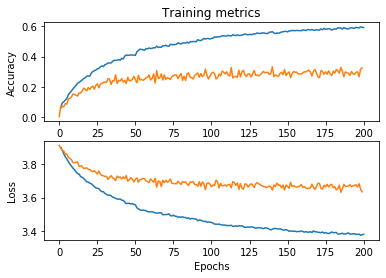

In [36]:
import matplotlib.pyplot as plt

x_axis = np.linspace(1,200,200)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

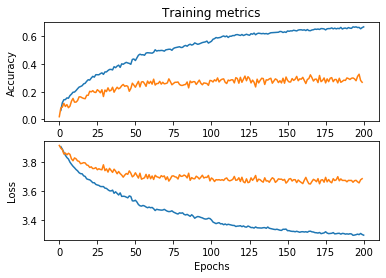

In [28]:
import matplotlib.pyplot as plt

x_axis = np.linspace(1,200,200)
plt.subplot(2, 1, 1)
plt.plot(x_axis, train_history, val_history)
plt.title('Training metrics')
plt.ylabel('Accuracy')

plt.subplot(2, 1, 2)
plt.plot(x_axis, train_loss_hist, val_loss_hist)
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()